In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

data = pd.read_csv('C:/Users/DENVER/Udacity/machine-learning\projects/toxic-comment-classification/train.csv')#load the dataset
test_data = pd.read_csv('C:/Users/DENVER/Downloads/test.csv/test.csv')
data.head() # have a look at the data


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\r\nWhy the edits made under my use...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\r\nMore\r\nI can't make any real suggestions...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [16]:
data.isnull().any() # check for empty entries

id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool

In [40]:
from keras.preprocessing.text import text_to_word_sequence
from nltk.corpus import stopwords

stop_words = stopwords.words('english')

# remove stop-words, numbers, and punctuation
def clean_data(data):
    clean_data = [] 
    for text in data:
        text = text_to_word_sequence(text)
        text = [word for word in text if  word.isalpha() ] #word not in stop_words and
        clean_data.append(text)

    return clean_data

In [41]:
from sklearn.model_selection import train_test_split

# split data into training and testing sets
comments_train, comments_test, labels_train, labels_test = train_test_split(data['comment_text'],\
                data[['toxic','severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']], test_size=0.2, random_state=42)

commennts_train = clean_data(comments_train)

In [42]:
# import keras library for preprocessing

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences


max_words = 20000  # maximum number of common wards to be considered
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(comments_train) # fit tokenizer on comments_train




In [43]:

# turn senteces into sequences 
tokenized_comments_train = tokenizer.texts_to_sequences(comments_train)
#tokenized_comments_test = tokenizer.texts_to_sequences(comments_test)
#tokenized_test_data = tokenizer.texts_to_sequences(test_data['comment_text'])
#tokenized_clean_data = tokenizer.texts_to_sequences(data['comment_text'])

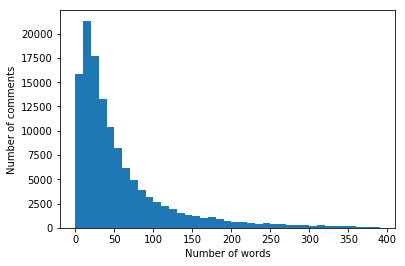

In [22]:
# visualize data
senteces_length = [len(comment) for comment in tokenized_comments_train]

plt.hist(senteces_length, bins=np.arange(0, 400, 10))
plt.ylabel('Number of comments')
plt.xlabel('Number of words')
plt.show()

In [44]:
# turn senteces to the same lenght(maxlen)
comments_length = 200
pad_comments_train = pad_sequences(tokenized_comments_train, maxlen=comments_length )
#pad_comments_test = pad_sequences(tokenized_comments_test, maxlen=comments_length)
#pad_test_data = pad_sequences(tokenized_test_data, maxlen=comments_length)
#pad_clean_data = pad_sequences(tokenized_clean_data,maxlen=comments_length)


In [56]:
# load GloVe word embedding file into the memory
embeddings_index = dict()
f = open('glove.twitter.27B.200d.txt','rb')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:],dtype='float32')
    embeddings_index[word] = coefs
    
f.close

<function BufferedReader.close>

In [57]:
# create a weight matrix for words in comments_train
embedding_matrix = np.zeros((max_words,200))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    


In [70]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPool1D,  Reshape, Flatten
from keras.layers import LSTM, GRU, Bidirectional, BatchNormalization # SpatialDropout1d,

#np.random.seed(42)

model = Sequential()
model.add(Embedding(max_words, 100, input_length=comments_length)) #, weights=[embedding_matrix], trainable=False))
#model.add(Reshape((1,200,128)))
#model.add(SpatialDropout1D(0.5))
#model.add(Conv1D(filters=20,kernel_size=2, padding='same', activation='relu'))
#model.add(MaxPooling1D(pool_size=2))
#model.add(Dropout(0.2))
#model.add(Conv2D(filters=20,kernel_size=2, padding='same', activation='relu'))
#model.add(Bidirectional(LSTM(80, return_sequences=True)))
#model.add(Bidirectional(GRU(60,return_sequences=True)))
model.add(LSTM(60,return_sequences=True))
model.add(GRU(60,return_sequences=True))
#model.add(MaxPooling1D(pool_size=2))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.1))
model.add(Dense(60, activation='relu'))
#model.add(BatchNormalization())
#model.add(Dense(60, activation='softmax'))
model.add(Dropout(0.1))
model.add(Dense(6, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 200, 100)          2000000   
_________________________________________________________________
lstm_4 (LSTM)                (None, 200, 60)           38640     
_________________________________________________________________
gru_2 (GRU)                  (None, 200, 60)           21780     
_________________________________________________________________
global_max_pooling1d_14 (Glo (None, 60)                0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 60)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 60)                3660      
_________________________________________________________________
dropout_28 (Dropout)         (None, 60)                0         
__________

In [ ]:
from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath='weights.best.h5py', verbose=1, save_best_only=True)

model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])
model.fit(pad_comments_train,labels_train, epochs=3,validation_split=0.1, callbacks=[checkpointer], batch_size=30)

Train on 114890 samples, validate on 12766 samples
Epoch 1/3
114890/114890 [==============================] - 1867s 16ms/step - loss: 0.0810 - acc: 0.9757 - val_loss: 0.0521 - val_acc: 0.9809

Epoch 00001: val_loss improved from inf to 0.05214, saving model to weights.best.h5py
Epoch 2/3
 11280/114890 [=>............................] - ETA: 26:47 - loss: 0.0487 - acc: 0.9821

In [83]:
from sklearn.metrics import roc_auc_score

class roc_callback(Callback):
    def __init__(self,training_data,validation_data):
        self.x = training_data[0]
        self.y = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]


    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.x)
        roc = roc_auc_score(self.y, y_pred)
        y_pred_val = self.model.predict(self.x_val)
        roc_val = roc_auc_score(self.y_val, y_pred_val)
        print('\rroc-auc: %s - roc-auc_val: %s' % (str(round(roc,4)),str(round(roc_val,4))),end=100*' '+'\n')
        return

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return
x_val = comments_train[107710:]
y_val = labels_train[107710:]
x_train = comments_train[:107710]
y_train = labels_train[:107710]


model.fit(x_train,y_train, validation_data=(x_val, y_val), epochs=5, batch_size=50, verbose=1,\
          callbacks=[roc_callback(training_data=(x_train,y_train),validation_data=(x_val, y_val)), checkpointer])

Train on 107710 samples, validate on 11968 samples
Epoch 1/5
107710/107710 [==============================] - 615s 6ms/step - loss: 0.1617 - acc: 0.9636 - val_loss: 0.1463 - val_acc: 0.9619
roc-auc: 0.5 - roc-auc_val: 0.5                                                                                                    

Epoch 00001: val_loss improved from inf to 0.14629, saving model to weights.best.h5py
Epoch 2/5
107710/107710 [==============================] - 8802s 82ms/step - loss: 0.1407 - acc: 0.9636 - val_loss: 0.1463 - val_acc: 0.9619
roc-auc: 0.5 - roc-auc_val: 0.5                                                                                                    

Epoch 00002: val_loss improved from 0.14629 to 0.14627, saving model to weights.best.h5py
Epoch 3/5
107710/107710 [==============================] - 627s 6ms/step - loss: 0.1407 - acc: 0.9636 - val_loss: 0.1462 - val_acc: 0.9619
roc-auc: 0.5 - roc-auc_val: 0.5                                                         

KeyboardInterrupt: 

In [79]:
pre = model.predict(pad_test_data)

In [97]:
predictions = model.predict(comments_test)

In [112]:
print(pre[0,:])

[ 0.30993235  0.09459998  0.22915576  0.0549183   0.21933208  0.09206153]


In [116]:
from sklearn.metrics import roc_auc_score

roc_auc = []
for i in range(5):
    roc_auc.append(roc_auc_score(labels_test.iloc[:,i], predictions[:,i]))
    
sum(roc_auc)/6

0.41676765809861677

In [80]:
submission = pd.DataFrame(pre, index=test_data['id'],\
                          columns=['toxic','severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])
submission.to_csv("submission.csv")